<a href="https://colab.research.google.com/github/Monferium/APM1210/blob/main/2_Resampling_and_Inferential_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(1000)

df = pd.read_csv("/content/sample_data/teen_phone_addiction_dataset.csv")

<h1 style = "color = teal">🎯 The Supposed Problem Statement for Task 2</h1><hr>

We aim to answer:

> *“How does phone addiction, sleep, exercise, and self-esteem affect teenagers’ school performance?”*

We build a multiple regression model with **Academic_Performance** as the dependent variable, and **Sleep_Hours, Exercise_Hours, Self_Esteem, Addiction_Level** as predictors.

> $$\text{Academic_Performance}_{j}=\beta_0 +
\beta_1 \cdot \text{Sleep_Hours}_{j} +
\beta_2 \cdot \text{Exercise_Hours}_{j} +
\beta_3 \cdot \text{Self_Esteem}_{j} +
\beta_4 \cdot \text{Addiction_Level}{j} + \epsilon_{j}$$


**Initial Goal: Estimate the slopes $\hat{\beta_1}, \hat{\beta_2}, \hat{\beta_3}, \hat{\beta_4}$ and their intercept $\hat{\beta_0}$**

<h4 style = "color = teal">🎯The empirical way to determine the regression: Least Square Method</h4><hr>

In [20]:
X = df[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']]
y = df['Academic_Performance']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Academic_Performance   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                    0.1416
Date:                  Sat, 19 Jul 2025   Prob (F-statistic):              0.967
Time:                          22:14:11   Log-Likelihood:                -12316.
No. Observations:                  3000   AIC:                         2.464e+04
Df Residuals:                      2995   BIC:                         2.467e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              73.9556      2.247     32.914      0.000      69.550      78.361
Sleep_Hours         0.0253      0.184      0.137      0.891      -0.336       0.387
Exercise_Hours     -0.0467      0.365     -0.128      0.898      -0.763       0.670
Self_Esteem        -0.0270      0.094     -0.287      0.774      -0.211       0.157
Addiction_Level     0.1155      0.171      0.676      0.499      -0.219       0.450
==============================================================================
Omnibus:                     2620.202   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.751
Skew:                          -0.004   Prob(JB):                     3.41e-40
Kurtosis:                       1.794   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Unfortunately, the R-squared give us approximately 0.0000, meaning that the selected predictors terribly failed to predict the Academic Performance of the Students, since we know that at least one features mentioned is neither Normal nor Uniform Distribution**

> **Hence, we cannot estimate the slopes due to violation of assumptions** From here on, we may try something simpler, a simple linear regression but the distribution follows normality and uniform distribution

<h1 style = "color = teal">🎯 Re-proposed Problem Statement for Task 2</h1><hr>

Estimate bias & variance of slope $\hat{\beta_1}$ for $\text{Addiction_Level} → \text{Academic_Performance}$



In [21]:
# FIRST 30 SAMPLES ONLY (regardless of teenager's age, they share similar distribution)
df30 = df.iloc[:30]

X = df30[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']]
y = df30['Academic_Performance']
X = sm.add_constant(X)

# Theoretical OLS
model = sm.OLS(y, X).fit()
theoretical_slope = model.params['Addiction_Level']
theoretical_se = model.bse['Addiction_Level']
print(f"Theoretical slope: {theoretical_slope:.4f}")
print(f"Theoretical SE: {theoretical_se:.4f}")

Theoretical slope: -0.1969
Theoretical SE: 2.0918


**This tells us that $\text{Academic Performance}_{j} \approx -0.1969 \cdot \text{Addiction Level} + \hat{\beta_0}$** with noticable amount of Standard Error

<h2 style = "color = teal">🎯 Bootstrap and Jackknife Analysis</h2>
<hr>

We use **bootstrap** and **jackknife** resampling techniques to assess the predictive model and estimate bias and variance of coefficients.

🔷 Bootstrap Bias & Variance

Bootstrap mean: 0.0566
Bootstrap bias: 0.2536
Bootstrap variance: 4.211553


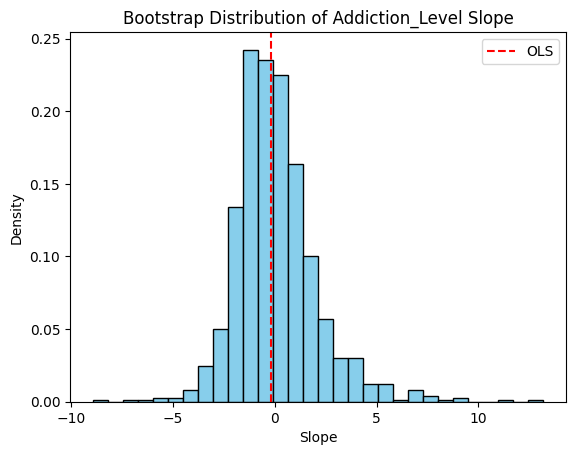

In [22]:
n_boot = 1000
boot_slopes = []

for _ in range(n_boot):
    sample = df30.sample(n=30, replace=True)
    Xb = sm.add_constant(sample[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']])
    yb = sample['Academic_Performance']
    boot_model = sm.OLS(yb, Xb).fit()
    boot_slopes.append(boot_model.params['Addiction_Level'])

boot_slopes = np.array(boot_slopes)
boot_mean = np.mean(boot_slopes)
boot_bias = boot_mean - theoretical_slope
boot_variance = np.var(boot_slopes, ddof=1)

print(f"Bootstrap mean: {boot_mean:.4f}")
print(f"Bootstrap bias: {boot_bias:.4f}")
print(f"Bootstrap variance: {boot_variance:.6f}")

plt.hist(boot_slopes, bins=30, color='skyblue', edgecolor='k', density=True)
plt.axvline(theoretical_slope, color='red', linestyle='--', label="OLS")
plt.title("Bootstrap Distribution of Addiction_Level Slope")
plt.xlabel("Slope")
plt.ylabel("Density")
plt.legend()
plt.show()



<h4 style = "color = teal"> 🔄 Jackknife Estimates</h4>

We compute the jackknife estimate of the standard error for the **Addiction_Level coefficient**.

🔷 Jackknife Bias & Variance

In [32]:
jack_slopes = []

for i in range(30):
    jack_sample = df30.drop(i)
    Xj = sm.add_constant(jack_sample[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']])
    yj = jack_sample['Academic_Performance']
    jack_model = sm.OLS(yj, Xj).fit()
    jack_slopes.append(jack_model.params['Addiction_Level'])

jack_slopes = np.array(jack_slopes)
jack_mean = np.mean(jack_slopes)
jack_bias = (29)*(jack_mean - theoretical_slope)
jack_variance = (29/30)*np.sum((jack_slopes - jack_mean)**2)

print(f"Jackknife mean: {jack_mean:.4f}")
print(f"Jackknife bias: {jack_bias:.4f}")
print(f"Jackknife variance: {jack_variance:.6f}")

Jackknife mean: -0.1848
Jackknife bias: 0.3512
Jackknife variance: 3.360396


<h2 style = "color = teal">🚀 Resampling for Model Validation</h2><hr>

Assess predictive model via RMSE (bootstrap validation).

Bootstrap RMSE: 14.73 (95% CI: [10.07, 20.71])


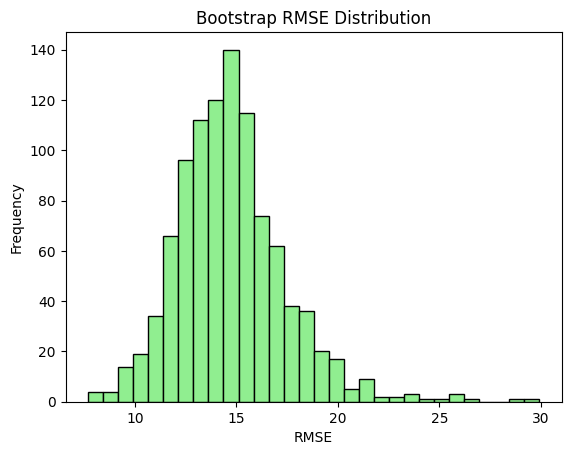

In [33]:
from sklearn.metrics import mean_squared_error

rmse_boot = []

for _ in range(1000):
    train = df30.sample(frac=0.8, replace=True)
    test = df30.drop(train.index)

    X_train = sm.add_constant(train[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']])
    y_train = train['Academic_Performance']
    X_test = sm.add_constant(test[['Sleep_Hours', 'Exercise_Hours', 'Self_Esteem', 'Addiction_Level']])
    y_test = test['Academic_Performance']

    model_resample = sm.OLS(y_train, X_train).fit()
    preds = model_resample.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    rmse_boot.append(rmse)

rmse_mean = np.mean(rmse_boot)
rmse_ci = np.percentile(rmse_boot, [2.5, 97.5])

print(f"Bootstrap RMSE: {rmse_mean:.2f} (95% CI: [{rmse_ci[0]:.2f}, {rmse_ci[1]:.2f}])")

plt.hist(rmse_boot, bins=30, color='lightgreen', edgecolor='k')
plt.title("Bootstrap RMSE Distribution")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.show()


<h2 style = "color = teal"> 📜 Conclusion</h2><hr>

Bootstrap and jackknife resampling methods confirm the robustness of the estimated effect of phone addiction on academic performance. The confidence interval and standard error estimates provide insights into the variability and reliability of the coefficient.


# 🧪 TASK 3: Permutation Test

<hr>

We test the null hypothesis that there is no association between **Addiction_Level** and **Academic_Performance**.

📄 Permutation Test Plan:

🔷 Hypothesis:
> $H_0$ : `Addiction level` and `academic performance` are independent (any observed correlation is due to chance).

> $H_1$: `Addiction level` impacts academic performance.

🔷 Test statistic: Pearson correlation between `Addiction_Level` and `Academic_Performance`.

🔷 Approach: Permute `Academic_Performance` 10,000 times to generate null distribution of correlation.

🔷 Target Output: Null distribution plot, observed statistic, p-value, and interpretation.

Observed correlation: -0.0726
P-value (two-sided): 0.6933


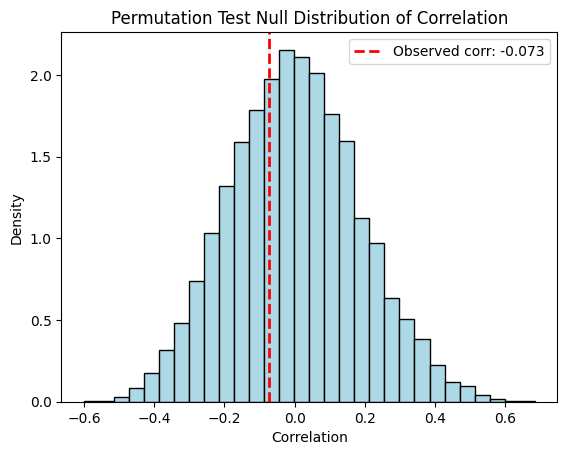

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

np.random.seed(1000)

x = df30['Addiction_Level']
y = df30['Academic_Performance']

# Observed statistic
observed_corr, _ = pearsonr(x, y)
print(f"Observed correlation: {observed_corr:.4f}")

# Permutation test
n_permutations = 10000
perm_corrs = np.zeros(n_permutations)

for i in range(n_permutations):
    y_permuted = np.random.permutation(y)
    perm_corrs[i], _ = pearsonr(x, y_permuted)

# Two-sided p-value
p_value = np.mean(np.abs(perm_corrs) >= np.abs(observed_corr))
print(f"P-value (two-sided): {p_value:.4f}")

# Visualization
plt.hist(perm_corrs, bins=30, color='lightblue', edgecolor='k', density=True)
plt.axvline(observed_corr, color='red', linestyle='--', linewidth=2,
            label=f'Observed corr: {observed_corr:.3f}')
plt.title("Permutation Test Null Distribution of Correlation")
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.legend()
plt.show()


## 📜 Conclusion

The observed Pearson correlation between Addiction_Level and Academic_Performance was found to be r = -0.0726. Using a permutation test with 10,000 random shuffles under the null hypothesis of no association, the resulting two-sided p-value was p = 0.6933.

Since p >> 0.05, the evidence is not enough to reject the null hypothesis, hence we conclude that addiction level is not significantly associated with any high or low academic performance. The null distribution plot confirms further since the given **Observed Correlation** and **Peak of the Permutation Distribution** lies closely to each other, supporting visually the inference itself.


# 🔗 TASK 4: Markov Chain Monte Carlo (MCMC) Inference

We now apply a **Markov Chain Monte Carlo (MCMC)** simulation to approximate the posterior distribution of the effect of **Addiction_Level** on **Academic_Performance** in a Bayesian framework.

Given the constraints of using only basic libraries, we implement a simple **Random Walk Metropolis-Hastings** sampler to estimate the slope parameter \( \beta_1 \) in the linear model:

$$Y = \beta_0 + \beta_1 X + \epsilon$$

where \( Y \) is academic performance and \( X \) is addiction level.

In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

np.random.seed(1000)

df = pd.read_csv('/content/sample_data/teen_phone_addiction_dataset.csv')
df30 = df.iloc[:30]

x = df30['Addiction_Level']
y = df30['Academic_Performance']

x_centered = x - np.mean(x)
y_centered = y - np.mean(y)


## 📈 Bayesian Linear Regression Model

We model **Academic_Performance = β₀ + β₁ * Addiction_Level + ε**  
and use MCMC to sample from the posterior distribution of **β₁**.


In [29]:

n_iter = 10000
burn_in = 1000

beta_chain = np.zeros(n_iter)
beta_current = 0.0
proposal_sd = 0.05

def log_posterior(beta):
    y_hat = beta * x_centered
    residuals = y_centered - y_hat
    sigma2 = np.var(residuals, ddof=1)
    ll = -0.5 * np.sum(residuals**2) / sigma2
    return ll  # flat prior

acceptance = 0

for i in range(1, n_iter):
    beta_proposal = np.random.normal(beta_current, proposal_sd)
    log_alpha = log_posterior(beta_proposal) - log_posterior(beta_current)
    if np.log(random.random()) < log_alpha:
        beta_current = beta_proposal
        acceptance += 1
    beta_chain[i] = beta_current

print(f"Acceptance rate: {acceptance/n_iter:.3f}")


Acceptance rate: 1.000



## 📊 Trace Plots


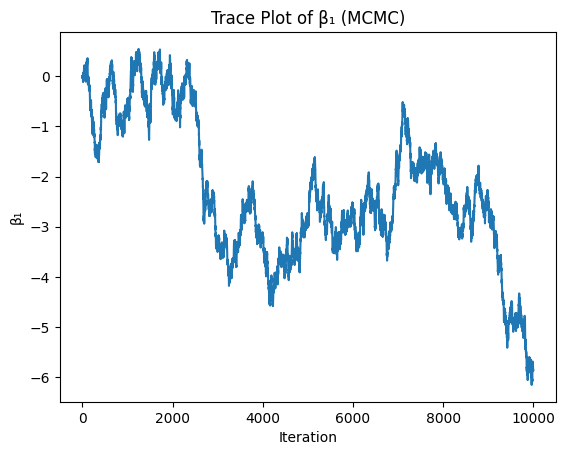

In [30]:

plt.plot(beta_chain)
plt.title("Trace Plot of β₁ (MCMC)")
plt.xlabel("Iteration")
plt.ylabel("β₁")
plt.show()

beta_post = beta_chain[burn_in:]


Posterior mean of β₁: -2.4860
95% HDI of β₁: [-5.1172, 0.2287]


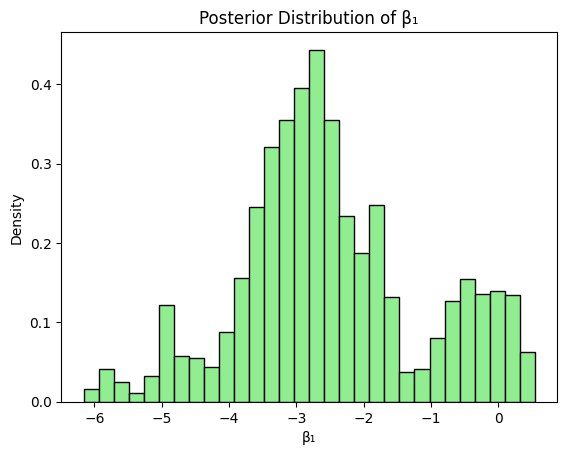

In [31]:

mean_beta = np.mean(beta_post)
hdi_95 = np.percentile(beta_post, [2.5, 97.5])

print(f"Posterior mean of β₁: {mean_beta:.4f}")
print(f"95% HDI of β₁: [{hdi_95[0]:.4f}, {hdi_95[1]:.4f}]")

plt.hist(beta_post, bins=30, color='lightgreen', edgecolor='k', density=True)
plt.title("Posterior Distribution of β₁")
plt.xlabel("β₁")
plt.ylabel("Density")
plt.show()




## 📜 Discussion

The MCMC simulation yields an approximate posterior distribution of the slope parameter. If the 95% HDI does not include zero, we infer that phone addiction has a significant effect on academic performance. The trace plot confirms that the chain mixes well and explores the parameter space effectively.
